# Field Analysis Demo

Field analysis is a calculation method that is intended for validating the expected locations of various discrete plant components (e.g. combiners). It identifies cloud motion within the individual component time series and infers their positions based upon relative timing of the cloud signal to each individual component. A full description of the technique is available in a paper: J. Ranalli and W. Hobbs, PV Plant Equipment Labels and Layouts can be Validated by Analyzing Cloud Motion in Existing Plant Measurements, Submitted to IEEE Journal of Photovoltaics.   

This demo utilizes sample data on a single plant to demonstrate the application of the method.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from solartoolbox import spatial, field

## Read the Data
The sample data file is a compressed H5 file that contains all the info used to perform the analysis. 

### The Plant Layout
The layout of the plant is placed in the variable `pos_utm`. Its definition is contained in the field `latlon`, which produces a DataFrame of the combiner centroids in a UTM-like coordinate system. It contains combiner IDs as the index, and columns `E` and `N` that indicate the mean position of the combiner footprint (i.e. the centroid). The combiners are named following the pattern `CMB-<INVERTER#>-<COMBINER#>`.

In [13]:
datafile = "data/sample_field.h5"
pos_utm = pd.read_hdf(datafile, mode="r", key="latlon")
pos_utm

,E,N
CMB-001-1,23.584970,1086.290244
CMB-001-2,49.679324,1086.290365
CMB-001-3,84.519736,1086.290633
CMB-001-4,125.324187,1086.291124
CMB-001-5,160.281453,1086.291697
...,...,...
CMB-048-4,695.084107,31.788344
CMB-048-5,729.924241,31.791192
CMB-048-6,764.894729,31.794191
CMB-048-7,799.739358,31.797319


### The Time Series Data
The method relies on two discrete time periods with a fixed CMV. Two examples are stored in the data file with keys `data_a` and `data_b`. These each represent one hour of data for each combiner in the plant with a 10s sampling resolution. The DataFrames are indexed by a time that is artificially offset to begin at a time of `00:00:00` on an arbitrary day. The columns of the DataFrames have keys that match the index of `pos_utm`. 

In [14]:
df_a = pd.read_hdf(datafile, mode="r", key="data_a")
df_b = pd.read_hdf(datafile, mode="r", key="data_b")
df_a

,CMB-001-1,CMB-001-2,CMB-001-3,CMB-001-4,CMB-001-5,CMB-001-6,CMB-001-7,CMB-002-1,CMB-002-2,CMB-002-3,...,CMB-047-7,CMB-047-8,CMB-048-1,CMB-048-2,CMB-048-3,CMB-048-4,CMB-048-5,CMB-048-6,CMB-048-7,CMB-048-8
2023-10-20 00:00:00,94.004660,94.191535,93.825414,94.524257,93.593720,93.664273,93.958268,95.461349,95.719286,95.927767,...,93.070936,93.000639,91.270596,91.580108,91.754487,91.728513,91.604793,91.947189,91.658315,91.806175
2023-10-20 00:00:10,94.715213,95.026591,95.235316,95.313226,94.059705,94.617467,94.747432,95.842825,95.969763,95.909135,...,92.952733,93.076070,91.488586,92.046498,91.844898,91.939824,92.043528,91.853341,91.672593,91.624886
2023-10-20 00:00:20,94.974593,95.454349,95.645314,96.036298,94.205323,94.944385,95.133431,95.812550,95.954695,95.473800,...,93.132510,92.933911,91.448184,91.995421,92.127925,91.927446,91.858514,91.925107,91.650284,91.690636
2023-10-20 00:00:30,95.088573,95.615394,95.345973,95.981233,94.237682,94.937895,95.262955,95.679329,96.124116,96.285184,...,93.141806,93.079938,91.639859,92.269237,92.138932,91.830187,91.735162,92.055243,91.627975,91.631461
2023-10-20 00:00:40,95.045343,95.747467,95.723331,96.036298,94.613061,94.905447,95.363743,95.546119,95.945735,95.734666,...,93.085711,92.953253,91.693416,92.210614,92.068175,91.732934,91.865540,91.888830,91.605665,91.777057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-20 00:59:10,14.133280,13.202007,14.655109,13.395783,12.881261,13.347467,14.003394,13.791540,13.315670,8.638013,...,14.273617,14.942827,15.556991,16.006977,15.974375,16.503697,15.470764,15.709592,14.897047,16.509679
2023-10-20 00:59:20,14.404453,13.254838,14.823617,13.414741,13.113848,13.495515,14.149646,13.751172,13.336033,8.324643,...,14.611813,15.441840,14.767255,15.301101,15.679551,17.480666,17.952487,17.909147,16.149065,16.690024
2023-10-20 00:59:30,14.615891,13.367315,14.889163,13.378633,13.346435,13.486185,14.236283,13.841595,13.356398,8.709157,...,14.643006,15.649762,14.721215,14.830516,14.572583,16.211933,18.050850,18.745121,17.931160,19.393341
2023-10-20 00:59:40,14.642615,13.516433,14.928968,13.546058,13.341177,13.703593,14.304906,13.964716,13.376761,8.400868,...,14.278542,15.224247,14.594368,14.520702,14.617396,15.746878,15.393478,15.898081,18.503179,23.342175


It's necessary to provide the CMV for each time period. These precomputed values for the time periods in the data file are provided here. It's also possible to compute them directly using methods in `solartoolbox.cmv`. Note that it's necessary for the CMVs to be roughly perpendicular, because the matrix calculation associated with triangulating the predicted position becomes singular for CMVs that are too close to parallel (or anti-parallel).

In [15]:
cmv_a = spatial.pol2rect(9.515372409962954, 0.6196401023982533)
cmv_b = spatial.pol2rect(8.486245566393151, 2.177365219628146)

## Perform the Field Analysis
A high level execution of the field routine for a single CMV pair is performed by `compute_predicted_position`. This routine works on a single combiner at a time and on a single CMV pair at a time. Running it in a loop allows multiple combiners to be tested (only 10 points are shown here, due to computational time considerations). It returns a variable (`com`) that holds the predicted position of the target combiner on the basis of other neighboring combiners that that serve as a spatial reference. The predicted position from each individual neighbor combiner is provided in the returned variable `pos`, which could be used to analyze the quality of the predictions. 

Results are stored in a new DataFrame (`df`).   

In [16]:
df = pd.DataFrame(index=pos_utm.index, columns=['E', 'N', 'com-E', 'com-N'])

for ref in pos_utm.index[46:62]:

    com, pos, _ = field.compute_predicted_position(
        [df_a, df_b],  # The dataframes with the two one hour periods
        pos_utm,  # the dataframe specifying the combiner positions
        ref,  # the combiner id to calculate the position for
        [cmv_a, cmv_b],  # The two individual CMVs for the DFs
        mode='preavg',  # Mode for downselecting the neighboring points
        ndownsel=8)  # Num points to use for downselecting

    # Add this combiner's calculated position to the output DataFrame
    df.loc[ref] = [pos_utm.loc[ref]['E'], pos_utm.loc[ref]['N'], com[0], com[1]]


## Results
The following code generates a plot showing the location of the combiners in the entire plant. The red lines indicate the difference between the expected and calculated positions of the combiners tested. The CMVs for the two time periods are indicated by the green and blue arrows to the side of the plot.

The results shown here indicate combiners whose predicted position generally agrees with the expected position from the plant design. It can be helpful to repeat this calculation for different CMV pairs and to average the positions to determine the degree to which the predictions are repeatable and independent of the CMV.  

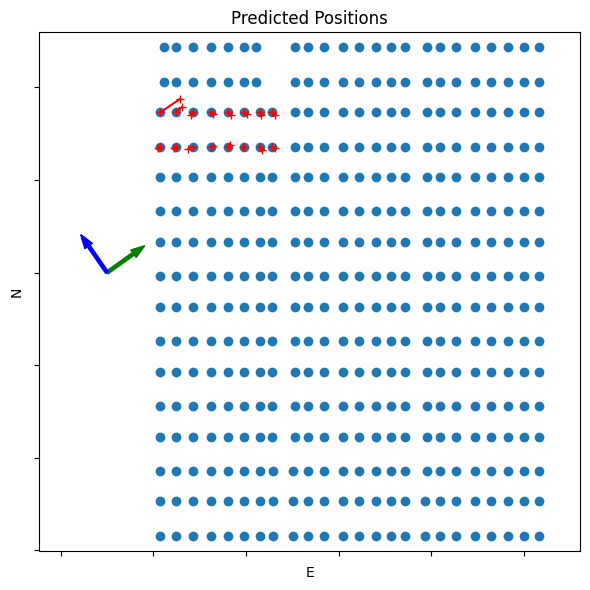

In [18]:
plt.figure(figsize=(6, 6))
plt.scatter(pos_utm['E'], pos_utm['N'])

for row in df.iterrows():
    r = row[1]
    plt.plot([r['E'], r['com-E']], [r['N'], r['com-N']], 'r-+')

# Plot some arrows to show the CMV
for cmv, color in zip([cmv_a, cmv_b],['green','blue']):
    velvec = np.array(spatial.unit(cmv)) * 100
    plt.arrow(-100, 600, velvec[0], velvec[1],
              length_includes_head=True, width=7, head_width=20, color=color)

plt.axis('equal')
plt.xlabel('E')
plt.ylabel('N')
plt.title(f'Predicted Positions')
axes = plt.gca()
axes.xaxis.set_ticklabels([])
axes.yaxis.set_ticklabels([])
plt.tight_layout()

plt.show()
